# Run VGG16 on 3 classes test1

For this part, we loads 3 classes with most paintings in VGG16 and adds several layers to test the performance. Still, run 20 epochs.

Before adding layers, we let the `base_model.output` load into variable `x`. Then, we just operate on the `x`. The operations are as following:
* A `Flatten()(x)` layer which reshapes the outputs to a single channel.
* A fully-connected layer with 2304 output units and `relu` activation.
* A `GaussianNoise(0.1)(x)` layer.
* A `Dropout(0.5)(x)` layer.
* A fully-connected layer with 288 output units and `relu` activation.
* A `BatchNormalization()(x)` layer.
* A `Dropout(0.5)(x)` layer.
* A final fully-connected layer.  Since this is a multiple classification, there should be three output and `softmax` activation. To mitigate overfitting, we add several arguments: `kernel_initializer='random_uniform'`, `bias_initializer='random_uniform'`, and `bias_regularizer=regularizers.l2(0.01)`.

However, at the end of this test1, we can still clearly see overfitting.

In [1]:
import numpy as np
import os
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout, Flatten, Dense, GaussianNoise, BatchNormalization
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13973592982641359775
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 15866717560866743607
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 17454529404844390179
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15856546612
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11389401770462418927
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


In [3]:
import tensorflow.keras.backend as K
K.clear_session()

Before adding layers, we let the `base_model.output` load into variable `x`. Then, we just operate on the `x`. The operations are as following:
* A `Flatten()(x)` layer which reshapes the outputs to a single channel.
* A fully-connected layer with 2304 output units and `relu` activation.
* A `GaussianNoise(0.1)(x)` layer.
* A `Dropout(0.5)(x)` layer.
* A fully-connected layer with 288 output units and `relu` activation.
* A `BatchNormalization()(x)` layer.
* A `Dropout(0.5)(x)` layer.
* A final fully-connected layer.  Since this is a multiple classification, there should be three output and `softmax` activation. To mitigate overfitting, we add several arguments: `kernel_initializer='random_uniform'`, `bias_initializer='random_uniform'`, and `bias_regularizer=regularizers.l2(0.01)`.

In [1]:
nrow = 200
ncol = 200
nclass = 3
base_model = applications.VGG16(weights='imagenet', input_shape=(nrow,ncol,3), include_top=False)
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(2304, activation = 'relu')(x) # 18432/4
x = GaussianNoise(0.1)(x) # add noise to mitigate overfitting (regularization layer)
x = Dropout(0.5)(x)
x = Dense(288, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
pred = Dense(nclass, activation='softmax', 
             kernel_initializer='random_uniform', 
             bias_initializer='random_uniform', 
             bias_regularizer=regularizers.l2(0.01), 
             name='predictions')(x) 
model = Model(inputs=base_model.input, outputs=pred)
    

NameError: name 'applications' is not defined

In [5]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 200, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0         
__________

In [6]:
train_data_dir = './images_train'
batch_size = 32
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(
                        train_data_dir,
                        target_size=(nrow,ncol),
                        batch_size=batch_size,
                        class_mode='categorical')

Found 1616 images belonging to 3 classes.


In [7]:
test_data_dir = './images_test'
batch_size = 32
test_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
test_generator = train_datagen.flow_from_directory(
                        test_data_dir,
                        target_size=(nrow,ncol),
                        batch_size=batch_size,
                        class_mode='categorical')

Found 402 images belonging to 3 classes.


In [8]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
steps_per_epoch = train_generator.n // batch_size
validation_steps = test_generator.n // batch_size

In [9]:
nepochs = 20  # Number of epochs

# Call the fit_generator function
hist = model.fit_generator(
    train_generator,
    epochs=nepochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_generator,
    validation_steps=validation_steps)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
51/51 [==============================] - 103s 2s/step - loss: 0.9238 - acc: 0.5811 - val_loss: 1.2578 - val_acc: 0.5821
Epoch 2/20
51/51 [==============================] - 88s 2s/step - loss: 0.6401 - acc: 0.7401 - val_loss: 0.6700 - val_acc: 0.7413
Epoch 3/20
51/51 [==============================] - 86s 2s/step - loss: 0.5565 - acc: 0.7642 - val_loss: 0.5407 - val_acc: 0.7836
Epoch 4/20
51/51 [==============================] - 87s 2s/step - loss: 0.4907 - acc: 0.7995 - val_loss: 0.5485 - val_acc: 0.8010
Epoch 5/20
51/51 [==============================] - 87s 2s/step - loss: 0.4413 - acc: 0.8280 - val_loss: 0.5116 - val_acc: 0.7910
Epoch 6/20
51/51 [==============================] - 88s 2s/step - loss: 0.4384 - acc: 0.8348 - val_loss: 0.4602 - val_acc: 0.8234
Epoch 7/20
51/51 [==============================] - 85s 2s/step - loss: 0.3880 - acc: 0.8484 - val_loss: 0.4421 - val_acc: 0.8209
Epoch 8/20
51/51 [=======================

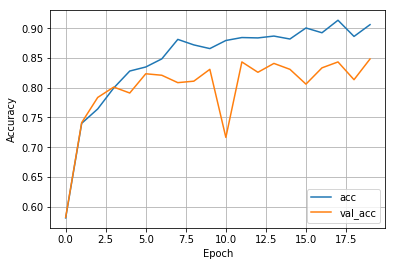

In [10]:
hist_his = hist.history
acc = hist_his['acc']
val_acc = hist_his['val_acc']
plt.plot(acc)
plt.plot(val_acc)
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['acc','val_acc'], loc = 4)

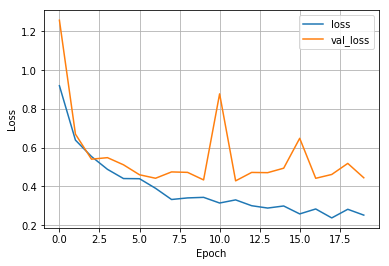

In [11]:
loss = hist_his['loss']
val_loss = hist_his['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['loss','val_loss'], loc = 1)

In [12]:
print(loss)
print(val_loss)
print(acc)
print(val_acc)

[0.9197668498105341, 0.6389658262233923, 0.5544988536598658, 0.4881614077799391, 0.44060463657473575, 0.43979209454933016, 0.3903113628673081, 0.33251514175150654, 0.34068196362788133, 0.3435912899451681, 0.3143471346633269, 0.3304667539230668, 0.3004123606894276, 0.2883142184207935, 0.29904315701805717, 0.2581148448556957, 0.283596468001309, 0.23742855900880133, 0.28195172607308566, 0.25184559349966523]
[1.2577795065366304, 0.6699514022240272, 0.5406953211014087, 0.5484803112653586, 0.5115789484519225, 0.4601581853169661, 0.44214536593510556, 0.47486457228660583, 0.4725213853212503, 0.43356338372597325, 0.8777518776746897, 0.42876676240792644, 0.47224560150733363, 0.47098710445257336, 0.4940937597018022, 0.6483332835710965, 0.44195979833602905, 0.46170809864997864, 0.5188222928689077, 0.444645609993201]
[0.58106434, 0.740099, 0.7642327, 0.79950494, 0.8279703, 0.83477724, 0.8483911, 0.8811881, 0.8719059, 0.8657178, 0.8793317, 0.8842822, 0.88366336, 0.88675743, 0.8818069, 0.9003713, 0.8